In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix


In [46]:
train_dir = 'C:/Users/DELL/Desktop/train'
test_dir  = 'C:/Users/DELL/Desktop/test'

In [47]:
categories = ["Tumor","No_Tumor"]

In [48]:
tumor_count = len(os.listdir("C:/Users/DELL/Desktop/train/Tumor"))
no_tumor_count = len(os.listdir("C:/Users/DELL/Desktop/train/No_Tumor"))

print("Tumor:", tumor_count)
print("NO_Tumor:", no_tumor_count)


Tumor: 1200
NO_Tumor: 1198


In [54]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [53]:
image_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 2398 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [56]:
labels, counts = np.unique(train_generator.classes ,return_counts=True)
class_names = list(train_generator.class_indices.keys())

print("Class indices:", train_generator.class_indices)
print("Labels count:", dict(zip(class_names, counts)))


Class indices: {'No_Tumor': 0, 'Tumor': 1}
Labels count: {'No_Tumor': np.int64(1198), 'Tumor': np.int64(1200)}


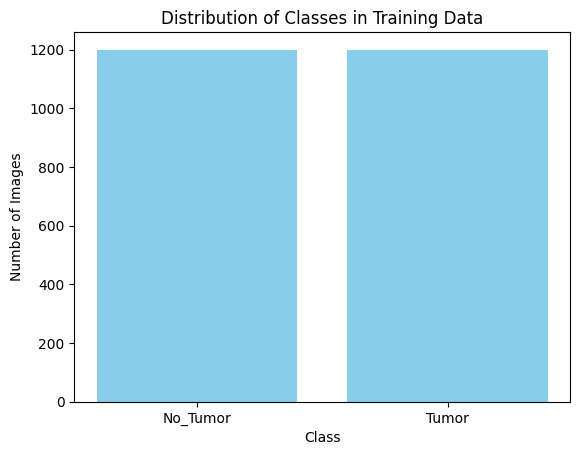

In [57]:
labels, counts = np.unique(train_generator.classes ,return_counts=True)
class_names = list(train_generator.class_indices.keys())

plt.bar(class_names, counts, color='skyblue')
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

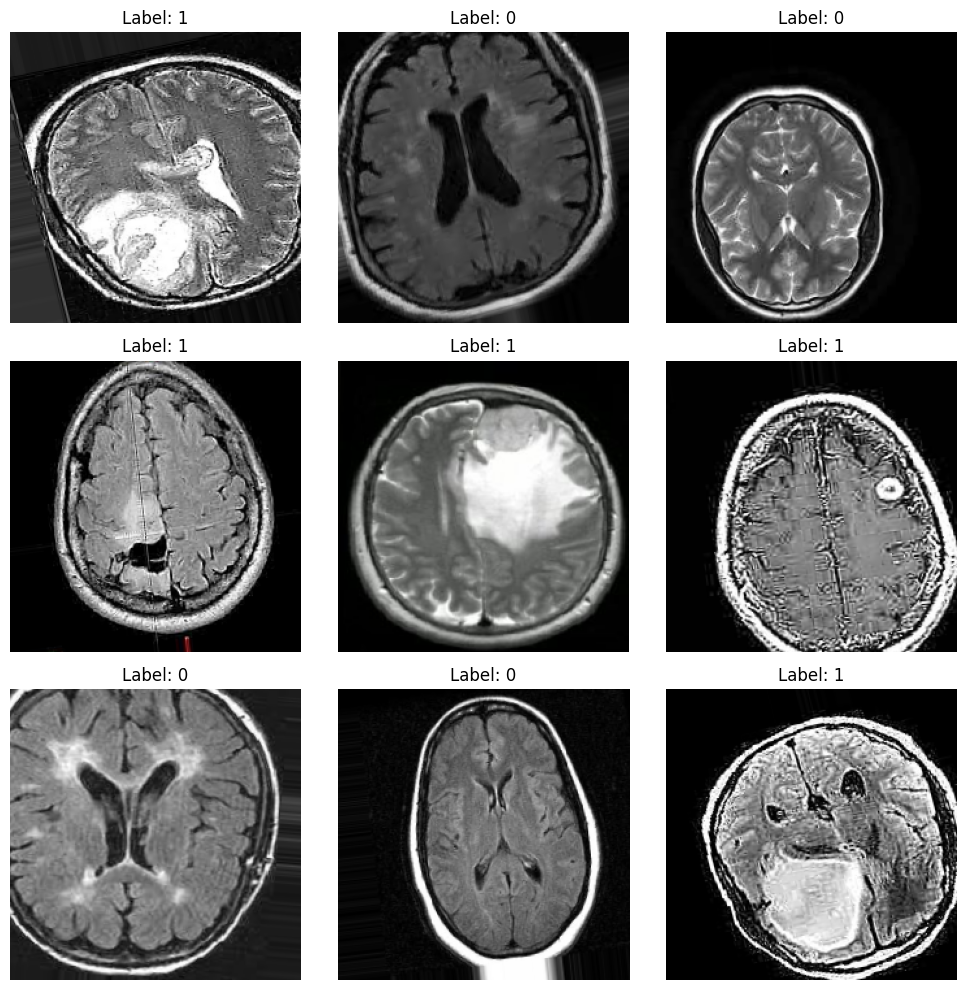

In [58]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {int(y_batch[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [59]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))


implmentation of CNN

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [13]:

model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.6),

    Dense(1, activation='sigmoid')  
])

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [24]:
epochs = 5

history = model1.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    class_weight=class_weights_dict,
    callbacks=[early_stop]

)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.7528 - loss: 0.5064 - val_accuracy: 0.7333 - val_loss: 0.6436
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7827 - loss: 0.4829 - val_accuracy: 0.6833 - val_loss: 0.7196
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7936 - loss: 0.4563 - val_accuracy: 0.8000 - val_loss: 0.4403
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8116 - loss: 0.4377 - val_accuracy: 0.7433 - val_loss: 0.5459
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.7845 - loss: 0.4488 - val_accuracy: 0.7283 - val_loss: 0.6388


In [ ]:
y_true = test_generator.classes
y_pred_prob = model1.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype("int").flatten()

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['Tumor', 'No_Tumor']))


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step
[[209  91]
 [ 29 271]]
              precision    recall  f1-score   support

       Tumor       0.88      0.70      0.78       300
    No Tumor       0.75      0.90      0.82       300

    accuracy                           0.80       600
   macro avg       0.81      0.80      0.80       600
weighted avg       0.81      0.80      0.80       600



In [26]:
loss, acc = model1.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 242ms/step - accuracy: 0.7360 - loss: 0.5357
Test Accuracy: 0.80


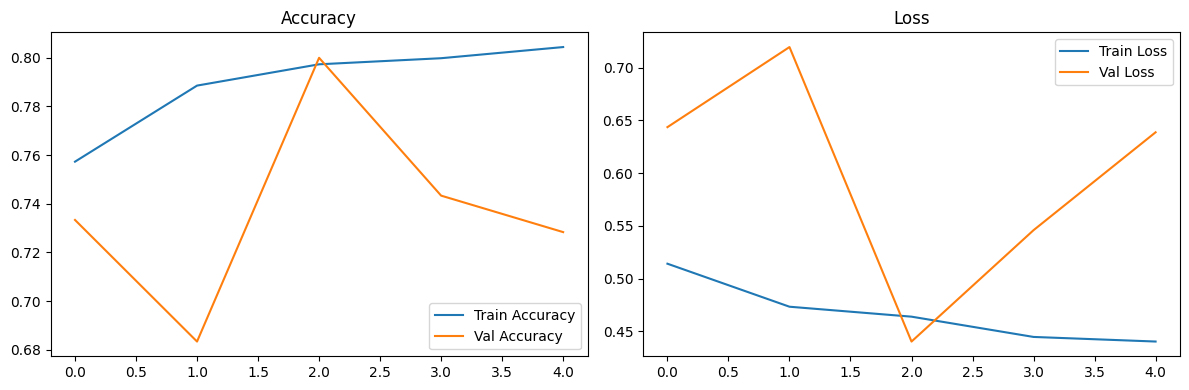

In [27]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model2

In [60]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

In [61]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [62]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

In [64]:
model = Model(inputs=base_model.input, outputs=predictions)

In [65]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stop]
)

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.4705 - loss: 1.1303 - val_accuracy: 0.6083 - val_loss: 0.6636
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.6408 - loss: 0.6882 - val_accuracy: 0.6533 - val_loss: 0.6144
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7261 - loss: 0.5586 - val_accuracy: 0.6833 - val_loss: 0.5701
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7675 - loss: 0.4869 - val_accuracy: 0.7217 - val_loss: 0.5209
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.7765 - loss: 0.4669 - val_accuracy: 0.7400 - val_loss: 0.5001
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.7961 - loss: 0.4308 - val_accuracy: 0.7867 - val_loss: 0.4387
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8086 - loss: 0.4155 - val_accuracy: 0.7667 - val_loss: 0.4529
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8227 - loss: 0.3883 - val_accuracy: 0.7933 - v

In [67]:
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(test_generator.classes, y_pred_classes))
print(classification_report(test_generator.classes, y_pred_classes, target_names=['No_Tumor', 'Tumor']))


19/19 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step
[[231  69]
 [ 13 287]]
              precision    recall  f1-score   support

    No_Tumor       0.95      0.77      0.85       300
       Tumor       0.81      0.96      0.88       300

    accuracy                           0.86       600
   macro avg       0.88      0.86      0.86       600
weighted avg       0.88      0.86      0.86       600



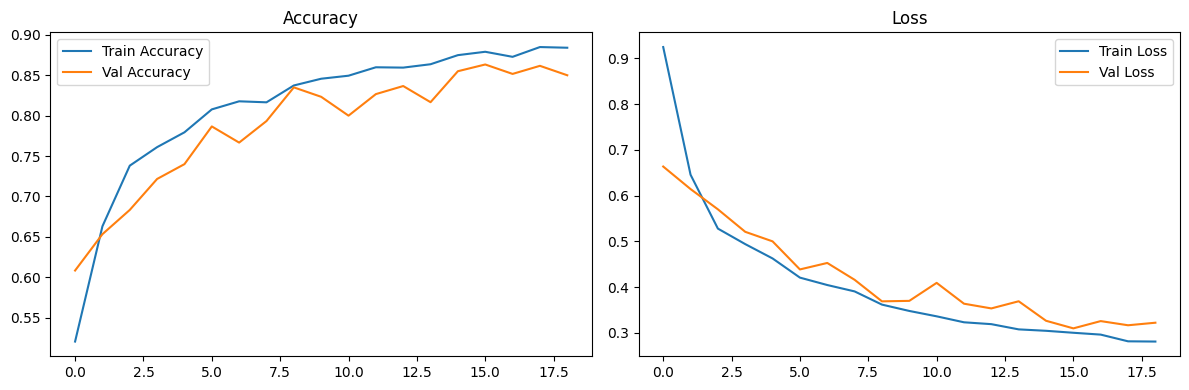

In [68]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
model.save("brain_classification_model.h5")
print("model 1 is the best")

model 1 is the best


object detection model

In [1]:
import os
import json
from PIL import Image
from tqdm import tqdm

In [2]:
BASE_DIR = r"C:/Users/DELL/Desktop/New folder"
SPLITS = ["train", "val", "test"]

In [1]:
import torch
from matplotlib import pyplot as plt
from PIL import Image

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\DELL/.cache\torch\hub\master.zip
YOLOv5  2025-5-1 Python-3.12.4 torch-2.6.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
C:\Users\DELL/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 351x278 1 tumor
Speed: 74.8ms pre-process, 3161.1ms inference, 3.0ms NMS per image at shape (1, 3, 640, 512)


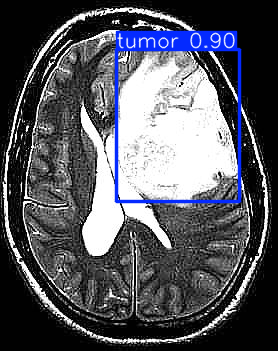

In [5]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='C:/Users/DELL/Desktop/exp/weights/best.pt', force_reload=True)


image_path = "C:/Users/DELL/Desktop/train/yes/y578.jpg" 


results = model(image_path)


results.print()             
results.show()              


plt.imshow(results.ims[0])   
plt.axis('off')
plt.title('find tumor')
plt.show()